In [0]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from fastai.tabular import *
from keras.models import Sequential
from keras.layers import Dense
import xgboost as xgb
from sklearn import tree, neighbors, datasets, linear_model, svm, naive_bayes, ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils.multiclass import unique_labels
# import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [121]:
data =pd.read_csv("ac_march_tweets.csv")
data.head()

,Date,Open,Close,Close -Min,Trump-Positive,Trump-Negative,Trump-Neutral,Others-Positive,Others-Negative,Others-Neutral
0,11/14/2017,978.5,978.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,11/15/2017,985.0,985.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,11/16/2017,983.0,983.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,11/17/2017,996.5,996.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,11/20/2017,998.5,998.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
add_datepart(data, 'Date')
data.drop('Elapsed', axis=1, inplace=True)

In [123]:
data.head()

,Open,Close,Close -Min,Trump-Positive,Trump-Negative,Trump-Neutral,Others-Positive,Others-Negative,Others-Neutral,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,978.5,978.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,46,14,1,318,False,False,False,False,False,False
1,985.0,985.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,46,15,2,319,False,False,False,False,False,False
2,983.0,983.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,46,16,3,320,False,False,False,False,False,False
3,996.5,996.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,46,17,4,321,False,False,False,False,False,False
4,998.5,998.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,47,20,0,324,False,False,False,False,False,False


In [124]:
data = data.drop(['Open', 'Year', 'Month',	'Week',	'Day',	'Dayofweek',	'Dayofyear', 'Is_month_end',	'Is_month_start',	'Is_quarter_end',	'Is_quarter_start',	'Is_year_end',	'Is_year_start'], axis =1)
data.head()

,Close,Close -Min,Trump-Positive,Trump-Negative,Trump-Neutral,Others-Positive,Others-Negative,Others-Neutral
0,978.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,985.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,983.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,996.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,998.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
lags = range(1, 31)
lags_trump = range(1,6)
lags_others = [1, 2 ]

data=data.assign(**{
    '{} (t-{})'.format('Close', t): data['Close'].shift(t)
    for t in lags
    for col in data
})
data=data.assign(**{
    '{} (t-{})'.format('Close -Min', t): data['Close -Min'].shift(t)
    for t in lags
    for col in data
})
data=data.assign(**{
    '{} (t-{})'.format('Trump-Positive', t): data['Trump-Positive'].shift(t)
    for t in lags_trump
    for col in data
})

data=data.assign(**{
    '{} (t-{})'.format('Trump-Negative', t): data['Trump-Negative'].shift(t)
    for t in lags_trump
    for col in data
})

data=data.assign(**{
    '{} (t-{})'.format('Trump-Neutral', t): data['Trump-Neutral'].shift(t)
    for t in lags_trump
    for col in data
})
data=data.assign(**{
    '{} (t-{})'.format('Others-Positive', t): data['Others-Positive'].shift(t)
    for t in lags_others
    for col in data
})

data=data.assign(**{
    '{} (t-{})'.format('Others-Negative', t): data['Others-Negative'].shift(t)
    for t in lags_others
    for col in data
})

data=data.assign(**{
    '{} (t-{})'.format('Others-Neutral', t): data['Others-Neutral'].shift(t)
    for t in lags_others
    for col in data
})
data.head()

,Close,Close -Min,Trump-Positive,Trump-Negative,Trump-Neutral,Others-Positive,Others-Negative,Others-Neutral,Close (t-1),Close (t-2),Close (t-3),Close (t-4),Close (t-5),Close (t-6),Close (t-7),Close (t-8),Close (t-9),Close (t-10),Close (t-11),Close (t-12),Close (t-13),Close (t-14),Close (t-15),Close (t-16),Close (t-17),Close (t-18),Close (t-19),Close (t-20),Close (t-21),Close (t-22),Close (t-23),Close (t-24),Close (t-25),Close (t-26),Close (t-27),Close (t-28),Close (t-29),Close (t-30),Close -Min (t-1),Close -Min (t-2),...,Close -Min (t-12),Close -Min (t-13),Close -Min (t-14),Close -Min (t-15),Close -Min (t-16),Close -Min (t-17),Close -Min (t-18),Close -Min (t-19),Close -Min (t-20),Close -Min (t-21),Close -Min (t-22),Close -Min (t-23),Close -Min (t-24),Close -Min (t-25),Close -Min (t-26),Close -Min (t-27),Close -Min (t-28),Close -Min (t-29),Close -Min (t-30),Trump-Positive (t-1),Trump-Positive (t-2),Trump-Positive (t-3),Trump-Positive (t-4),Trump-Positive (t-5),Trump-Negative (t-1),Trump-Negative (t-2),Trump-Negative (t-3),Trump-Negative (t-4),Trump-Negative (t-5),Trump-Neutral (t-1),Trump-Neutral (t-2),Trump-Neutral (t-3),Trump-Neutral (t-4),Trump-Neutral (t-5),Others-Positive (t-1),Others-Positive (t-2),Others-Negative (t-1),Others-Negative (t-2),Others-Neutral (t-1),Others-Neutral (t-2)
0,978.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,985.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,978.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,983.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,985.0,978.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,996.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,983.0,985.0,978.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,998.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,996.5,983.0,985.0,978.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
data=data.iloc[31:452,]
data.shape

(421, 89)

In [0]:
train=data.iloc[:340,]
test=data.iloc[340:,]

In [128]:
print(list(train.columns))

['Close', 'Close -Min', 'Trump-Positive', 'Trump-Negative', 'Trump-Neutral', 'Others-Positive', 'Others-Negative', 'Others-Neutral', 'Close (t-1)', 'Close (t-2)', 'Close (t-3)', 'Close (t-4)', 'Close (t-5)', 'Close (t-6)', 'Close (t-7)', 'Close (t-8)', 'Close (t-9)', 'Close (t-10)', 'Close (t-11)', 'Close (t-12)', 'Close (t-13)', 'Close (t-14)', 'Close (t-15)', 'Close (t-16)', 'Close (t-17)', 'Close (t-18)', 'Close (t-19)', 'Close (t-20)', 'Close (t-21)', 'Close (t-22)', 'Close (t-23)', 'Close (t-24)', 'Close (t-25)', 'Close (t-26)', 'Close (t-27)', 'Close (t-28)', 'Close (t-29)', 'Close (t-30)', 'Close -Min (t-1)', 'Close -Min (t-2)', 'Close -Min (t-3)', 'Close -Min (t-4)', 'Close -Min (t-5)', 'Close -Min (t-6)', 'Close -Min (t-7)', 'Close -Min (t-8)', 'Close -Min (t-9)', 'Close -Min (t-10)', 'Close -Min (t-11)', 'Close -Min (t-12)', 'Close -Min (t-13)', 'Close -Min (t-14)', 'Close -Min (t-15)', 'Close -Min (t-16)', 'Close -Min (t-17)', 'Close -Min (t-18)', 'Close -Min (t-19)', 'Close

In [0]:
train_y=train[['Close']]
train_x=train[['Close (t-1)', 'Close (t-2)', 'Close (t-3)', 'Close (t-4)', 'Close (t-5)', 'Close (t-6)', 'Close (t-7)', 'Close (t-8)', 'Close (t-9)', 'Close (t-10)', 'Close (t-11)', 'Close (t-12)', 'Close (t-13)', 'Close (t-14)', 'Close (t-15)', 'Close (t-16)', 'Close (t-17)', 'Close (t-18)', 'Close (t-19)', 'Close (t-20)', 'Close (t-21)', 'Close (t-22)', 'Close (t-23)', 'Close (t-24)', 'Close (t-25)', 'Close (t-26)', 'Close (t-27)', 'Close (t-28)', 'Close (t-29)', 'Close (t-30)', 'Close -Min (t-1)', 'Close -Min (t-2)', 'Close -Min (t-3)', 'Close -Min (t-4)', 'Close -Min (t-5)', 'Close -Min (t-6)', 'Close -Min (t-7)', 'Close -Min (t-8)', 'Close -Min (t-9)', 'Close -Min (t-10)', 'Close -Min (t-11)', 'Close -Min (t-12)', 'Close -Min (t-13)', 'Close -Min (t-14)', 'Close -Min (t-15)', 'Close -Min (t-16)', 'Close -Min (t-17)', 'Close -Min (t-18)', 'Close -Min (t-19)', 'Close -Min (t-20)', 'Close -Min (t-21)', 'Close -Min (t-22)', 'Close -Min (t-23)', 'Close -Min (t-24)', 'Close -Min (t-25)', 'Close -Min (t-26)', 'Close -Min (t-27)', 'Close -Min (t-28)', 'Close -Min (t-29)', 'Close -Min (t-30)', 'Trump-Positive (t-1)', 'Trump-Positive (t-2)', 'Trump-Positive (t-3)', 'Trump-Positive (t-4)', 'Trump-Positive (t-5)', 'Trump-Negative (t-1)', 'Trump-Negative (t-2)', 'Trump-Negative (t-3)', 'Trump-Negative (t-4)', 'Trump-Negative (t-5)', 'Trump-Neutral (t-1)', 'Trump-Neutral (t-2)', 'Trump-Neutral (t-3)', 'Trump-Neutral (t-4)', 'Trump-Neutral (t-5)', 'Others-Positive (t-1)', 'Others-Positive (t-2)', 'Others-Negative (t-1)', 'Others-Negative (t-2)', 'Others-Neutral (t-1)', 'Others-Neutral (t-2)']]

test_y=test[['Close']]
test_x=test[['Close (t-1)', 'Close (t-2)', 'Close (t-3)', 'Close (t-4)', 'Close (t-5)', 'Close (t-6)', 'Close (t-7)', 'Close (t-8)', 'Close (t-9)', 'Close (t-10)', 'Close (t-11)', 'Close (t-12)', 'Close (t-13)', 'Close (t-14)', 'Close (t-15)', 'Close (t-16)', 'Close (t-17)', 'Close (t-18)', 'Close (t-19)', 'Close (t-20)', 'Close (t-21)', 'Close (t-22)', 'Close (t-23)', 'Close (t-24)', 'Close (t-25)', 'Close (t-26)', 'Close (t-27)', 'Close (t-28)', 'Close (t-29)', 'Close (t-30)', 'Close -Min (t-1)', 'Close -Min (t-2)', 'Close -Min (t-3)', 'Close -Min (t-4)', 'Close -Min (t-5)', 'Close -Min (t-6)', 'Close -Min (t-7)', 'Close -Min (t-8)', 'Close -Min (t-9)', 'Close -Min (t-10)', 'Close -Min (t-11)', 'Close -Min (t-12)', 'Close -Min (t-13)', 'Close -Min (t-14)', 'Close -Min (t-15)', 'Close -Min (t-16)', 'Close -Min (t-17)', 'Close -Min (t-18)', 'Close -Min (t-19)', 'Close -Min (t-20)', 'Close -Min (t-21)', 'Close -Min (t-22)', 'Close -Min (t-23)', 'Close -Min (t-24)', 'Close -Min (t-25)', 'Close -Min (t-26)', 'Close -Min (t-27)', 'Close -Min (t-28)', 'Close -Min (t-29)', 'Close -Min (t-30)', 'Trump-Positive (t-1)', 'Trump-Positive (t-2)', 'Trump-Positive (t-3)', 'Trump-Positive (t-4)', 'Trump-Positive (t-5)', 'Trump-Negative (t-1)', 'Trump-Negative (t-2)', 'Trump-Negative (t-3)', 'Trump-Negative (t-4)', 'Trump-Negative (t-5)', 'Trump-Neutral (t-1)', 'Trump-Neutral (t-2)', 'Trump-Neutral (t-3)', 'Trump-Neutral (t-4)', 'Trump-Neutral (t-5)', 'Others-Positive (t-1)', 'Others-Positive (t-2)', 'Others-Negative (t-1)', 'Others-Negative (t-2)', 'Others-Neutral (t-1)', 'Others-Neutral (t-2)']]

LSTM

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_y)

In [0]:
x_train, y_train = [], []
for i in range(60,len(train_y)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [132]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=150, batch_size=10, verbose=2)

Epoch 1/150
 - 5s - loss: 0.0962
Epoch 2/150
 - 2s - loss: 0.0170
Epoch 3/150
 - 2s - loss: 0.0131
Epoch 4/150
 - 2s - loss: 0.0111
Epoch 5/150
 - 2s - loss: 0.0099
Epoch 6/150
 - 2s - loss: 0.0094
Epoch 7/150
 - 2s - loss: 0.0089
Epoch 8/150
 - 2s - loss: 0.0084
Epoch 9/150
 - 2s - loss: 0.0075
Epoch 10/150
 - 2s - loss: 0.0073
Epoch 11/150
 - 2s - loss: 0.0068
Epoch 12/150
 - 2s - loss: 0.0065
Epoch 13/150
 - 2s - loss: 0.0065
Epoch 14/150
 - 2s - loss: 0.0063
Epoch 15/150
 - 2s - loss: 0.0058
Epoch 16/150
 - 2s - loss: 0.0059
Epoch 17/150
 - 2s - loss: 0.0061
Epoch 18/150
 - 2s - loss: 0.0058
Epoch 19/150
 - 2s - loss: 0.0060
Epoch 20/150
 - 2s - loss: 0.0056
Epoch 21/150
 - 2s - loss: 0.0050
Epoch 22/150
 - 2s - loss: 0.0052
Epoch 23/150
 - 2s - loss: 0.0050
Epoch 24/150
 - 2s - loss: 0.0048
Epoch 25/150
 - 2s - loss: 0.0047
Epoch 26/150
 - 2s - loss: 0.0046
Epoch 27/150
 - 2s - loss: 0.0045
Epoch 28/150
 - 2s - loss: 0.0052
Epoch 29/150
 - 2s - loss: 0.0044
Epoch 30/150
 - 2s - lo

In [0]:
new_data=data['Close']

In [0]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(test_y) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [0]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [136]:
rms=np.sqrt(np.mean(np.power((test_y-closing_price),2)))
rms

Close    10.709416
dtype: float64

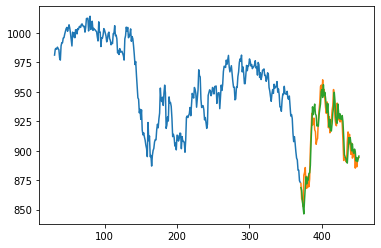

In [137]:
#for plotting
test_result=test_y
test_result['predict']=closing_price
plt.plot(train['Close'])
plt.plot(test_result[['Close','predict']])